In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F  # Import functional API for Leaky ReLU
import torch.optim as optim

torch.manual_seed(42)

In [2]:
# Solve with Analytical Solution
# Solve with Numerical Method
# Solve with NN (Vary learning rate, activation function, architecture)
# Evaluate numerical method for different CFL numbers, see how the NN handles it

In [3]:
# Parameters
nx = 500  # Number of spatial grid points
L = 5.0  # Length of the domain
dt = 0.01 # Time step
a = 1.0   # Advection speed
T = 5.0   # Total simulation time
nt = int(T / dt)  # Number of time steps
dx = L / (nx - 1)  # Spatial resolution

# Grid points
x = np.linspace(0, L, nx)

CFL = a * dt / dx
print(f"CFL Number: {CFL}")

# Initial condition: Gaussian pulse
def initial_condition(x):
    return np.exp(-((x - L/4) / 0.1) ** 2)

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 25)  # Input: (x, t)
        self.fc2 = nn.Linear(25, 25)
        self.fc3 = nn.Linear(25, 25)
        self.fc4 = nn.Linear(25, 1)  # Output: u(x, t)

    # Relu gives weird results which have these straight lines.
    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = F.tanh(self.fc1(inputs))
        out = F.tanh(self.fc2(out))
        out = F.tanh(self.fc3(out))
        out = self.fc4(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
# The sum of these expressions (du/dt and du_dx) should be zero, so we take the sum of these squared as the loss
# We find the gradients of the 
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x)**2)

# The IC loss comes from 
def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true)**2)

for epoch in range(10000):
    optimizer.zero_grad()
    
    # Sample random collocation points. 300 random values of x and t within the domain
    num_samples = 300  
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.uniform(0, T, num_samples), dtype=torch.float32).reshape(-1, 1)
    
    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss = loss_pde + loss_ic
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


CFL Number: 0.9980000000000001
Epoch 0, Loss: 0.08279643207788467
Epoch 1000, Loss: 0.005474064964801073
Epoch 2000, Loss: 0.00011829876893898472
Epoch 3000, Loss: 1.6749052520026453e-05
Epoch 4000, Loss: 6.54691848467337e-06
Epoch 5000, Loss: 4.1523471736582e-06
Epoch 6000, Loss: 2.7456362658995204e-06
Epoch 7000, Loss: 1.7668597138253972e-05
Epoch 8000, Loss: 4.3313852984283585e-06
Epoch 9000, Loss: 2.359073278057622e-06


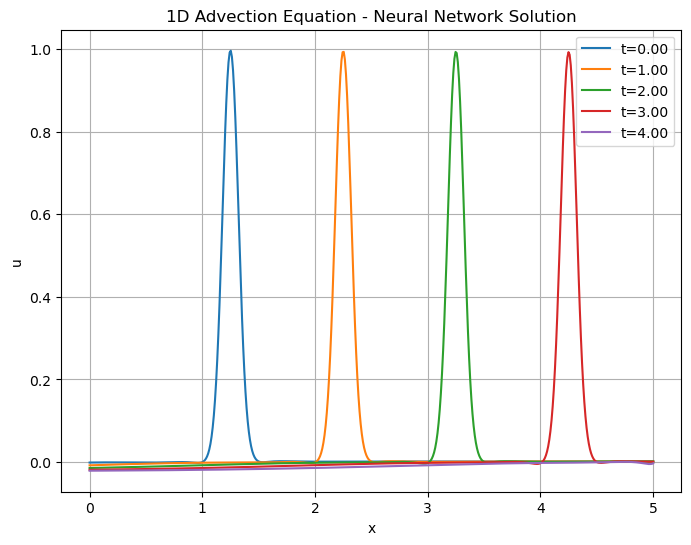

In [4]:
# Plot the results
plt.figure(figsize=(8, 6))
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot at specific time intervals
for n in range(0, nt, 100):
    t_test = torch.full_like(x_test, n * dt) # Creates a vector with the same shape as x_test with a constant value equal to n*dt
    with torch.no_grad(): 
        u_pred = model(x_test, t_test).detach().numpy()  # Detach tensor before converting to NumPy
    plt.plot(x, u_pred, label=f"t={n*dt:.2f}")

plt.title('1D Advection Equation - Neural Network Solution')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.savefig('plots/nn_1d.png')
plt.show()

In [2]:
# Parameters
nx = 500  # Number of spatial grid points
L = 5.0  # Length of the domain
dt = 0.01  # Time step
a = 1.0  # Advection speed
T = 5.0  # Total simulation time
nt = int(T / dt)  # Number of time steps
dx = L / (nx - 1)  # Spatial resolution

# Grid points
x = np.linspace(0, L, nx)
t = np.linspace(0, T, int(T/dt))

CFL = a * dt / dx
print(f"CFL Number: {CFL}")

# Initial condition: Gaussian pulse
def initial_condition(x):
    return np.exp(-((x - L / 4) / 0.1) ** 2)

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input: (x, t)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = torch.sin(self.fc1(inputs))
        out = torch.sin(self.fc2(out))
        out = torch.sin(self.fc3(out))
        out = torch.sin(self.fc4(out))
        out = torch.sin(self.fc5(out))
        out = self.fc6(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

# Training loop
for epoch in range(15000):
    optimizer.zero_grad()

    # Sample random collocation points
    num_samples = 500
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.choice(t, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 3*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

CFL Number: 0.9980000000000001
Epoch 0, Loss: 0.060847207903862, PDE Loss: 0.0023221741430461407, IC Loss: 0.037924814969301224, Boundary Loss: 0.015955867245793343
Epoch 1000, Loss: 0.002719833515584469, PDE Loss: 0.00025396409910172224, IC Loss: 0.0017505781725049019, Boundary Loss: 0.0002073631330858916
Epoch 2000, Loss: 0.00022094580344855785, PDE Loss: 5.0045360694639385e-05, IC Loss: 2.619622682686895e-05, Boundary Loss: 4.4613498175749555e-05
Epoch 3000, Loss: 8.179745054803789e-05, PDE Loss: 9.177955689665396e-06, IC Loss: 1.475750013923971e-05, Boundary Loss: 3.9506081520812586e-05
Epoch 4000, Loss: 3.087482036789879e-05, PDE Loss: 4.48440596301225e-06, IC Loss: 4.600501142704161e-06, Boundary Loss: 1.2821099517168477e-05
Epoch 5000, Loss: 0.00012006240285700187, PDE Loss: 3.5239886528870557e-06, IC Loss: 3.926148929167539e-05, Boundary Loss: 7.022894715191796e-05
Epoch 6000, Loss: 1.0124364052899182e-05, PDE Loss: 1.6706247834008536e-06, IC Loss: 2.136190460078069e-06, Bounda

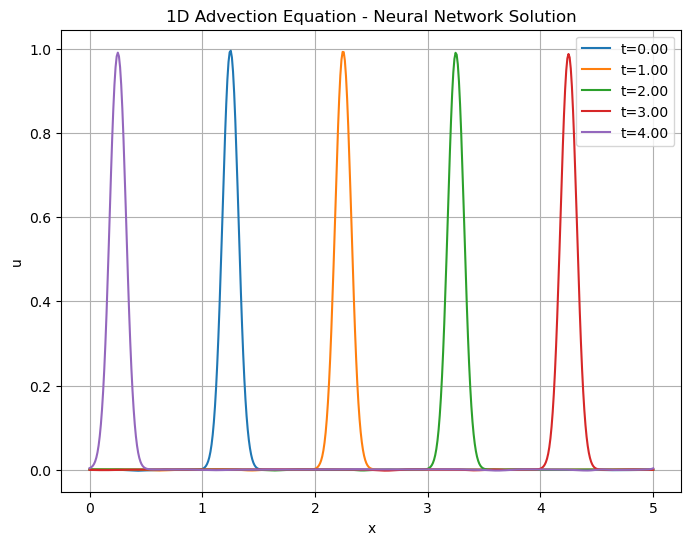

In [3]:
# Plot the results
plt.figure(figsize=(8, 6))
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot at specific time intervals
for n in range(5):
    t_test = torch.full_like(x_test, n) # Creates a vector with the same shape as x_test with a constant value equal to n
    with torch.no_grad(): 
        u_pred = model(x_test, t_test).detach().numpy()  # Detach tensor before converting to NumPy
    plt.plot(x, u_pred, label=f"t={n:.2f}")

plt.title('1D Advection Equation - Neural Network Solution')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.savefig('plots/nn_1d.png')
plt.show()